In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import glob

'\nimport plaidml.keras\nplaidml.keras.install_backend()\nos.environ["KERAS_BACKEND"] = "plaidml.keras.backend"\n'

In [2]:
print('Current working directory: ',os.getcwd())

Current working directory:  /content


## Dataset path location using glob

## Access Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_path='/content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/dataset_building/train'
test_path='/content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/dataset_building/test'

In [7]:
print(os.listdir(train_path))
print(os.listdir(test_path))

['mosque', 'mud_house', 'temple', 'tinshed', 'brick_house', 'skyscraper']
['tinshed', 'mud_house', 'mosque', 'temple', 'brick_house', 'skyscraper']


## Dataset Preprocessing using ImageDataGenerator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
WIDTH=224
HEIGHT=224

In [10]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    shear_range=0.1 ,
                                    zoom_range=0.1,
                                    rotation_range=20,
                                    height_shift_range=0.1,
                                    fill_mode='nearest',
                                    validation_split=0.2)
                                     
train_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT),
                                                 class_mode='categorical',
                                                 subset='training')

validation_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical',
                                                 subset='validation')

Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [11]:
test_generator=ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(batch_size=32,
                                                 directory=test_path,
                                                 shuffle=False,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical')

Found 300 images belonging to 6 classes.


In [ ]:
train_dataset.class_indices

{'brick_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'skyscraper': 3,
 'temple': 4,
 'tinshed': 5}

In [ ]:
validation_dataset.class_indices

{'brick_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'skyscraper': 3,
 'temple': 4,
 'tinshed': 5}

In [ ]:
total_class=len(train_dataset.class_indices)
print('Number of classes in dataset: ',total_class)

Number of classes in dataset:  6


## Plot some random image
- class 0: brick house
- class 1: mosque
- class 2: mud house
- class 3: skyscraper
- class 4: temple
- class 5: tinshed

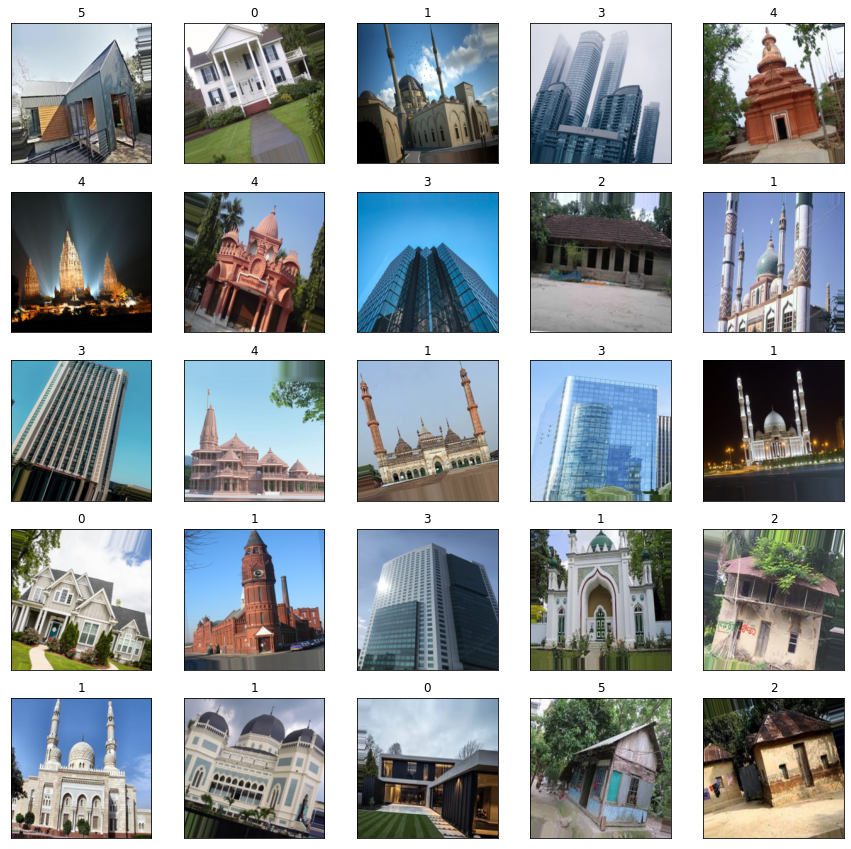

In [ ]:
x,y=train_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

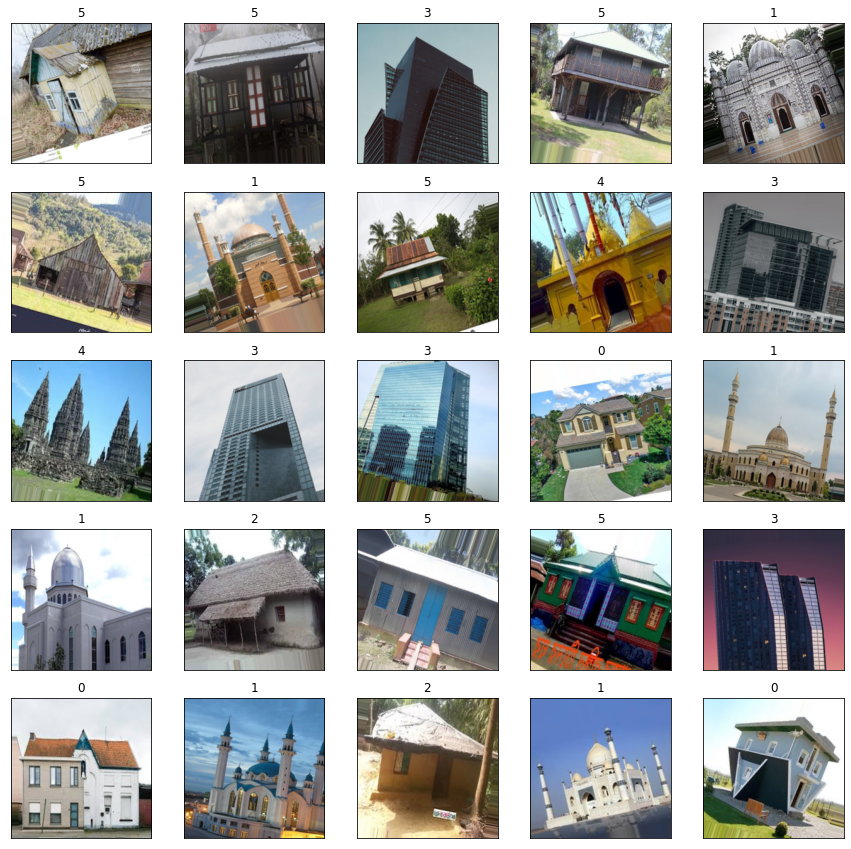

In [ ]:
x,y=validation_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Import ResNet

In [12]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers
import tensorflow as tf

In [13]:
base_model=ResNet152V2(input_shape=(224,224,3),include_top=False)

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
#base_model.summary()

In [15]:
base_model.trainable=False

In [17]:
total_class=6

In [18]:
model = tf.keras.Sequential([
  base_model,
  layers.GlobalAvgPool2D(),
  #layers.Dense(1024,activation='relu'),
  layers.Dense(total_class,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 58,343,942
Trainable params: 12,294
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

## Compile the model

In [19]:
model.compile( loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Trained the model

In [20]:
epochs=50
batch_size=32
trainset_length=len(train_dataset.labels)
validation_length=len(validation_dataset.labels)
steps_per_epoch=(trainset_length//batch_size)
validation_steps=(validation_length//batch_size)
print(trainset_length)
print(validation_length)
print(steps_per_epoch)
print(validation_steps)

960
240
30
7


In [21]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/Notebooks/ResNet.model.best.hdf5', verbose=1 ,save_best_only=True)

In [22]:
history = model.fit(train_dataset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    callbacks=[checkpointer])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.6635 
Epoch 1: val_loss improved from inf to 0.47866, saving model to /content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/Notebooks/ResNet.model.best.hdf5
30/30 [==============================] - 671s 22s/step - loss: 0.9289 - accuracy: 0.6635 - val_loss: 0.4787 - val_accuracy: 0.8348
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8635
Epoch 2: val_loss improved from 0.47866 to 0.35103, saving model to /content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/Notebooks/ResNet.model.best.hdf5
30/30 [==============================] - 29s 952ms/step - loss: 0.3969 - accuracy: 0.8635 - val_loss: 0.3510 - val_accuracy: 0.8705
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9104
Epoch 3: val_loss improved from 0.35103 to 0.27894, saving model to /content/drive/MyDrive/CSE 4000 All Documents 

## Plot Accuracy and Loss Graph

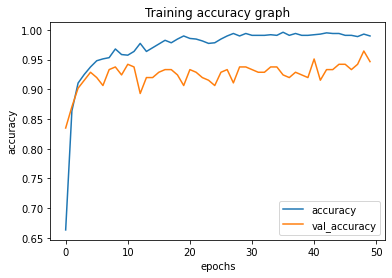

In [23]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training accuracy graph')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

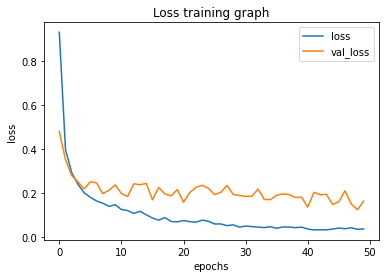

In [24]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss training graph')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

## Softmax activation fuction

three class labels will be integer encoded as 0, 1, and 2. Then encoded to vectors as follows:

- Class 0: [1, 0, 0]
- Class 1: [0, 1, 0]
- Class 2: [0, 0, 1]

The softmax output might look as follows, which puts the most weight on class 1 and less weight on the other classes.

[0.09003057 0.66524096 0.24472847] -> [0,1,0]

<b>equaltion</b> e^z/sum (e^z1,...,e^zn)

## Adam optimzer

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

## Testing data using test set

In [25]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print('Test Loss: ',test_loss)
print('Test Accuracy: ',test_accuracy)

10/10 [==============================] - 151s 17s/step - loss: 0.3051 - accuracy: 0.8833
Test Loss:  0.3050788938999176
Test Accuracy:  0.8833333253860474


In [26]:
print('Accuracy of the model is : ',test_accuracy*100)

Accuracy of the model is :  88.33333253860474


In [27]:
from sklearn.metrics import classification_report

test_pred_raw = model.predict(test_dataset)
test_labels = np.asarray(test_dataset.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_dataset.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_dataset.class_indices)

              precision    recall  f1-score   support

           0       0.86      0.64      0.74        50
           1       0.94      0.94      0.94        50
           2       0.96      0.90      0.93        50
           3       1.00      1.00      1.00        50
           4       0.94      0.90      0.92        50
           5       0.68      0.92      0.78        50

    accuracy                           0.88       300
   macro avg       0.90      0.88      0.88       300
weighted avg       0.90      0.88      0.88       300

{'brick_house': 0, 'mosque': 1, 'mud_house': 2, 'skyscraper': 3, 'temple': 4, 'tinshed': 5}


In [28]:
#True and predicted value calculation
class_labels = list(test_dataset.class_indices.keys())
predictions = []
true        = []
ctr         = 0
for batch, label in test_dataset:
    prediction = model.predict(batch).argmax(axis = -1)
    predictions.extend(prediction)
    true.extend(label.argmax(axis = -1))
    ctr += len(prediction)
    if ctr >= len(test_dataset.labels):
        break

#Defining function for confusion matrix plot 
from sklearn.metrics import confusion_matrix    
matrix  = confusion_matrix(true,predictions)
print(matrix)

[[32  0  0  0  1 17]
 [ 1 47  0  0  2  0]
 [ 0  0 45  0  0  5]
 [ 0  0  0 50  0  0]
 [ 2  3  0  0 45  0]
 [ 2  0  2  0  0 46]]


In [29]:
matrix.ravel()

array([32,  0,  0,  0,  1, 17,  1, 47,  0,  0,  2,  0,  0,  0, 45,  0,  0,
        5,  0,  0,  0, 50,  0,  0,  2,  3,  0,  0, 45,  0,  2,  0,  2,  0,
        0, 46])

In [30]:
print(predictions)

[0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0, 5, 5, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 0, 0, 5, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 0, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [31]:
print(true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


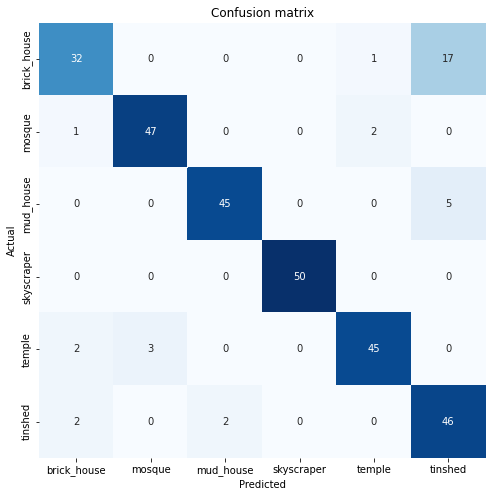

In [32]:
classnames = ['brick_house', 'mosque','mud_house', 'skyscraper', 'temple', 'tinshed']
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(matrix, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [35]:
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(true, predictions)))

print('Precision: {:.4f}'.format(precision_score(true, predictions,average='micro')))
print('Recall: {:.4f}'.format(recall_score(true, predictions,average='micro')))
print('F1-score: {:.4f}\n'.format(f1_score(true, predictions,average='micro')))


print('\nClassification Report:\n')
print(classification_report(true, predictions, 
                            target_names = ['brick_house', 'mosque','mud_house', 'skyscraper', 'temple', 'tinshed']))


Accuracy: 0.8833

Precision: 0.8833
Recall: 0.8833
F1-score: 0.8833


Classification Report:

              precision    recall  f1-score   support

 brick_house       0.86      0.64      0.74        50
      mosque       0.94      0.94      0.94        50
   mud_house       0.96      0.90      0.93        50
  skyscraper       1.00      1.00      1.00        50
      temple       0.94      0.90      0.92        50
     tinshed       0.68      0.92      0.78        50

    accuracy                           0.88       300
   macro avg       0.90      0.88      0.88       300
weighted avg       0.90      0.88      0.88       300



## Evaluate the model using test image

- class 0: brick house
- class 1: mosque
- class 2: mud house
- class 3: skyscraper
- class 4: temple
- class 5: tinshed

In [36]:
from tensorflow.keras.preprocessing import image

(1, 224, 224, 3)
[[9.2545855e-01 6.3924286e-05 9.1376230e-03 7.3151517e-04 3.4486354e-04
  7.0340514e-01]]
0


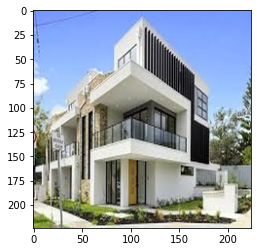

In [ ]:
path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/train/building_house/building_house0.png'
random_image=image.load_img(path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

In [ ]:
images_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images'
os.listdir(images_path)

['mosque23.png',
 'mosque35.png',
 'building_house1.png',
 'building_house6.png',
 'building_house5.png',
 'mosque1.png',
 'mosque0.png',
 'mosque76.png',
 'temple25.png',
 'temple33.png',
 'temple72.png',
 'sky12.png',
 'sky73.png',
 'sky79.png',
 'tinshed25.png',
 'tinshed113.png',
 'tinshed117.png',
 'mud60.png',
 'mud72.png',
 'mud92.png']

(1, 224, 224, 3)
[[1.3958387e-03 9.9926740e-01 1.5572737e-03 4.1701989e-03 3.9061170e-02
  2.0220694e-04]]
1


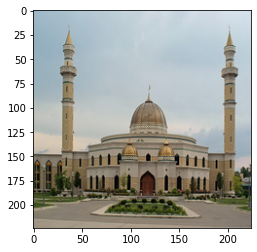

In [ ]:

path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/mosque0.png'
random_image=image.load_img(path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[6.9994210e-05 1.8360662e-04 9.9998116e-01 7.2198270e-07 3.8407892e-02
  1.2286730e-03]]
2


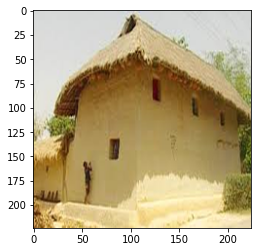

In [ ]:

path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/mud72.png'
random_image=image.load_img(path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[4.4792538e-04 5.2565731e-05 6.9510000e-04 9.9986017e-01 3.4396220e-03
  3.0831277e-04]]
3


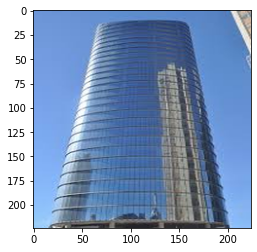

In [ ]:

path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/sky12.png'
random_image=image.load_img(path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[1.2973911e-06 1.7137831e-03 1.2885426e-06 5.2305620e-07 9.9993849e-01
  2.3304105e-05]]
4


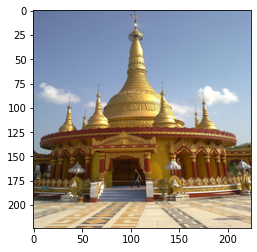

In [ ]:

path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/temple33.png'
random_image=image.load_img(path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[1.41809464e-01 1.03227554e-04 2.45439276e-01 9.16343051e-05
  4.33828682e-05 9.95369613e-01]]
5


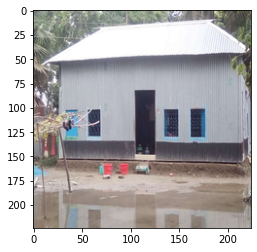

In [ ]:

path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/tinshed117.png'
random_image=image.load_img(path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

## Save Model h5 format
This file includes
- Model architecture
- Model weight values during training
- model training config 
- optimizer 

In [ ]:
saved_model='/content/drive/MyDrive/CSE 4000 Thesis/Transfer Learning TF Keras/'

In [37]:
import time
t = time.time()
#export_path_keras = "Saved Model/VGG16_model_{}_time_{}.h5".format(test_accuracy,int(t))
export_path_keras = "/content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/Notebooks/ResNet152v2_model_{}_time_{}.h5".format(test_accuracy,int(t))
print(export_path_keras)
model.save(export_path_keras)

/content/drive/MyDrive/CSE 4000 All Documents and Research Paper (NEW)/Notebooks/ResNet152v2_model_0.8833333253860474_time_1648291722.h5


## Reload the model h5 format

In [38]:
from tensorflow.keras.models import load_model

In [39]:
reload_model=load_model(export_path_keras)
reload_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 58,343,942
Trainable params: 12,294
Non-trainable params: 58,331,648
_________________________________________________________________


## Experiment with reload model h5 format

In [40]:
print(len(reload_model.weights))
print(reload_model.output_shape)

816
(None, 6)


## Plot and Check

In [ ]:
train_classes=train_dataset.class_indices
train_classes

In [ ]:
class_names=train_classes.keys()
class_names

In [ ]:
train_classes.values()